===========================================================================
RELATÓRIO TÉCNICO: NOTEBOOK 02 - MODELO DE LEAD SCORING INSIGHTOS
===========================================================================
Autora: Jessica Rocha
Data: 01 de setembro de 2025
---
## Resumo do Processo de Modelagem
Este relatório documenta o fluxo de trabalho completo executado no notebook 02_lead_scoring_model.ipynb, que transforma os dados brutos da InsightOS num artefato de machine learning treinado e pronto para avaliação. O processo seguiu uma metodologia rigorosa, onde cada etapa foi informada pelas descobertas da fase anterior, garantindo a construção de um modelo robusto e alinhado com as melhores práticas da indústria.
### 1. Preparação do Ambiente e Ingestão de Dados
O trabalho iniciou-se com a configuração de um ambiente de análise seguro e a extração dos dados brutos. Através de uma conexão segura com o banco de dados da InsightOS, utilizando credenciais geridas por dotenv, as tabelas users e user_events foram carregadas como DataFrames do pandas. Uma inspeção inicial validou a integridade e o formato dos dados, garantindo um ponto de partida fiável para a análise.
### 2. Engenharia de Atributos e Análise Exploratória (EDA)
A etapa seguinte foi a mais crucial: a transformação dos dados. Os dados de eventos, de natureza cronológica, foram agregados e consolidados com os dados de utilizadores para criar uma única feature_table. Nesta tabela analítica, cada linha representa um único lead e cada coluna uma característica descritiva do seu comportamento.
A Análise Exploratória desta tabela revelou três insights fundamentais que guiaram todo o resto do projeto:
1. Desequilíbrio de Classes: Foi confirmado que apenas 10.1% dos leads convertem, um desequilíbrio significativo que exige tratamento específico na modelagem.
2. Impacto Preditivo: A campanha de marketing google_gestao_agil demonstrou ter uma correlação visivelmente positiva com a conversão, identificando-a como uma feature de alto valor.
3. Multicolinearidade: O teste de Fator de Inflação da Variância (VIF) detetou uma forte redundância entre os eventos de trial_signup e user_verified, levando à decisão estratégica de remover uma destas variáveis no modelo final para garantir a sua estabilidade.
### 3. Pré-processamento e Pipeline de Treinamento
Com base nas descobertas da EDA, foi construído um pipeline de pré-processamento e modelagem automatizado.
* Baseline e Divisão: Foi estabelecido um modelo DummyClassifier como ponto de referência de performance. Os dados foram então divididos em conjuntos de treino e teste de forma estratificada, uma ação direta para garantir que o desequilíbrio de classes fosse representado corretamente em ambas as amostras.
* Pipeline de Transformação: Utilizando o ColumnTransformer do Scikit-learn, foi criado um preprocessor para aplicar StandardScaler às features numéricas e OneHotEncoder às categóricas.
* Treinamento do Modelo: Este pré-processador foi integrado num Pipeline final juntamente com um classificador LogisticRegression. O modelo foi configurado com o parâmetro class_weight='balanced', uma segunda medida técnica para mitigar o efeito do desequilíbrio de classes. O pipeline completo foi então treinado utilizando apenas os dados de treino.
### 4. Conclusão e Persistência do Artefato
O processo culminou com a persistência do pipeline treinado num ficheiro lead_scoring_pipeline_v1.joblib. O resultado é um artefato de machine learning completo e autocontido, que encapsula toda a lógica de pré-processamento e o modelo preditivo. Este sistema está agora pronto para a fase final: a avaliação de performance em dados nunca vistos.

In [ ]:
# --- CÉLULA 1: IMPORTAÇÕES E CONFIGURAÇÃO DA CONEXÃO ---

# Começo por importar todas as bibliotecas que vou precisar nesta análise.
import os
import pandas as pd  # A minha ferramenta principal para manipulação de dados.
import numpy as np   # Para operações numéricas.
from supabase import create_client, Client # Para me conectar à API do Supabase.
from dotenv import load_dotenv, find_dotenv # Para carregar as minhas credenciais de forma segura.
import seaborn as sns # Para criar visualizações estatísticas mais apelativas.
import matplotlib.pyplot as plt # A base para a maioria das visualizações em Python.
from statsmodels.stats.outliers_influence import variance_inflation_factor # Uma ferramenta específica para detetar multicolinearidade.
import json # Preciso desta biblioteca para conseguir ler os dados JSON que guardei no banco.

# Uma pequena configuração do pandas para garantir que consigo ver todas as colunas quando imprimir um DataFrame.
pd.set_option('display.max_columns', None)

print("CÉLULA 1: Bibliotecas importadas com sucesso.")

# Agora, estabeleço a conexão com o meu banco de dados no Supabase.
try:
    #CORREÇÃO: Uso find_dotenv() para garantir que o ficheiro .env seja encontrado,
    # mesmo que o notebook esteja a ser executado de uma subpasta.
    load_dotenv(find_dotenv()) 
    url: str = os.environ.get("SUPABASE_URL")
    key: str = os.environ.get("SUPABASE_KEY")
    
    if not url or not key:
        raise ValueError("Credenciais do Supabase não encontradas. Preciso de verificar o meu ficheiro .env.")
        
    supabase: Client = create_client(url, key)
    print("Conexão com o Supabase estabelecida com sucesso!")
except Exception as e:
    print(f"Erro ao conectar com o Supabase: {e}")

CÉLULA 1: Bibliotecas importadas com sucesso.
Conexão com o Supabase estabelecida com sucesso!


In [2]:
# --- CÉLULA 2: CARREGAMENTO DOS DADOS BRUTOS ---

# Com a conexão estabelecida, o próximo passo é buscar os dados que populei anteriormente.
print("\nCÉLULA 2: A carregar dados das tabelas 'users' e 'user_events'...")

try:
    # Busco todos os registos (*) da tabela 'users'.
    response_users = supabase.table('users').select('*').execute()
    users_df = pd.DataFrame(response_users.data)
    print(f"Carregados {len(users_df)} registos da tabela 'users'.")

    # Faço o mesmo para a tabela 'user_events'.
    response_events = supabase.table('user_events').select('*').execute()
    events_df = pd.DataFrame(response_events.data)
    print(f"Carregados {len(events_df)} registos da tabela 'user_events'.")

except Exception as e:
    print(f"Ocorreu um erro ao carregar os dados: {e}")

# É sempre uma boa prática inspecionar os dados logo após o carregamento.
# O .head() mostra-me as primeiras 5 linhas para eu ter a certeza de que tudo veio corretamente.
print("\nAmostra da tabela 'users':")
print(users_df.head())
print("\nAmostra da tabela 'user_events':")
print(events_df.head())


CÉLULA 2: A carregar dados das tabelas 'users' e 'user_events'...
Carregados 1000 registos da tabela 'users'.
Carregados 1000 registos da tabela 'user_events'.

Amostra da tabela 'users':
   user_id                            visitor_id                       email  \
0       22  7b00a8d9-54fb-4563-9a87-8ea62227d0ee      ericbutler@example.org   
1       30  2aeaa79a-7ae5-4bb6-bedd-a72f3a84a67e         tflores@example.org   
2       40  c8fcb99d-bc0d-47b6-8d28-2bc9c8ffe5b7      qmccormick@example.net   
3       51  0b0e33a7-f128-4a63-a1d9-85e3b9e7ea0e         sonya68@example.org   
4       60  8a2cbb4b-c400-4e84-9c17-fb5b5cba2d20  elliottmatthew@example.org   

                 signup_date   plan  status  lead_score  
0  2025-07-30T21:12:52+00:00  trial  active      0.0034  
1  2025-05-31T19:03:59+00:00  trial  active      0.0029  
2  2025-07-11T03:30:14+00:00  trial  active      0.0029  
3  2025-08-07T01:56:53+00:00  trial  active      0.0021  
4  2025-06-05T07:50:45+00:00  trial  act

In [3]:
# --- CÉLULA 3: CRIAÇÃO DA FEATURE TABLE (ENGENHARIA DE ATRIBUTOS) ---

print("\nCÉLULA 3: A iniciar a criação da feature table...")

# Esta é a etapa mais importante. O meu objetivo é criar uma única tabela
# onde cada linha representa um único utilizador, e as colunas representam
# características (features) que descrevem o comportamento desse utilizador.

# 1. Contagem de eventos por utilizador.
# A tabela 'events_df' está num formato "longo" (várias linhas por utilizador).
# Preciso de a transformar num formato "largo", onde cada tipo de evento se torna uma coluna.
# A função pivot_table é perfeita para isto.
events_pivot = events_df.pivot_table(
    index='visitor_id',   # Quero que cada linha seja um 'visitor_id'.
    columns='event_type', # Quero que cada 'event_type' se torne uma coluna.
    aggfunc='size',       # A minha função de agregação é 'size', que simplesmente conta as ocorrências.
    fill_value=0          # Se um utilizador não tiver um evento, o valor será 0.
)

# Para clareza, renomeio as novas colunas para indicar que são contagens de eventos.
events_pivot.columns = ['events_' + col for col in events_pivot.columns]

print("\nTabela de contagem de eventos criada (events_pivot):")
print(events_pivot.head())


# 2. Extração da campanha de marketing (primeiro toque).
# A informação da campanha está guardada como um JSON na coluna 'first_touch' do evento 'trial_signup'.
# Primeiro, filtro a tabela de eventos para obter apenas as linhas de 'trial_signup'.
signup_events = events_df[events_df['event_type'] == 'trial_signup'].copy()

# Agora, aplico uma função a cada linha da coluna 'first_touch'.
# A função 'lambda' é um atalho para criar uma pequena função anónima.
# Ela lê o texto JSON, converte-o num objeto Python e extrai o valor da chave 'campaign'.
signup_events['campaign'] = signup_events['first_touch'].apply(
    lambda x: json.loads(x).get('campaign') if x else None
)

# Crio um novo DataFrame apenas com o 'visitor_id' e a campanha, que é o que preciso para a junção.
campaign_df = signup_events[['visitor_id', 'campaign']]

print("\nTabela de campanhas de marketing extraída (campaign_df):")
print(campaign_df.head())


# 3. Junção (Merge) de todas as tabelas.
# Agora, vou unir as três tabelas que preparei: users_df, events_pivot e campaign_df.

# Começo por juntar a tabela de utilizadores com a de contagem de eventos.
# Uso um 'left' join para garantir que mantenho todos os utilizadores da tabela 'users',
# mesmo que, por algum motivo, não tenham eventos associados.
feature_table = pd.merge(
    users_df, 
    events_pivot, 
    on='visitor_id', 
    how='left'
)

# Agora, junto o resultado com a tabela de campanhas.
feature_table = pd.merge(
    feature_table,
    campaign_df,
    on='visitor_id',
    how='left'
)

# Após as junções, podem aparecer valores nulos (NaN).
# Por exemplo, se um utilizador não teve um evento, a sua contagem será NaN.
# Substituo todos esses NaN por 0.
event_cols = [col for col in feature_table.columns if 'events_' in col]
feature_table[event_cols] = feature_table[event_cols].fillna(0)


# 4. Criação da nossa variável-alvo (target).
# O objetivo do meu modelo é prever a conversão. A coluna 'status' contém essa informação.
# Crio uma nova coluna 'target_converted' que será 1 se o status for 'converted' e 0 caso contrário.
# O .astype(int) converte os valores True/False para 1/0.
feature_table['target_converted'] = (feature_table['status'] == 'converted').astype(int)

print("\nFeature table final criada:")
print(feature_table.head())
print(f"\nDimensões da feature table: {feature_table.shape}")


CÉLULA 3: A iniciar a criação da feature table...

Tabela de contagem de eventos criada (events_pivot):
                                      events_project_created  \
visitor_id                                                     
001058fd-5955-4500-856c-eb6eb4c3419b                       0   
0048b747-2c56-4566-9b67-eb8782ab7e7a                       1   
01391557-9961-49dd-a6ed-a9afdf9982d4                       0   
01d3b69e-8173-485e-96eb-3b2ed28db3aa                       1   
01e8ebec-02c4-4f1f-9be4-5ddb76f5c337                       0   

                                      events_subscription_started  \
visitor_id                                                          
001058fd-5955-4500-856c-eb6eb4c3419b                            0   
0048b747-2c56-4566-9b67-eb8782ab7e7a                            0   
01391557-9961-49dd-a6ed-a9afdf9982d4                            0   
01d3b69e-8173-485e-96eb-3b2ed28db3aa                            0   
01e8ebec-02c4-4f1f-9be4-5ddb76f5


CÉLULA 4: A iniciar a Análise Exploratória dos Dados (EDA)...


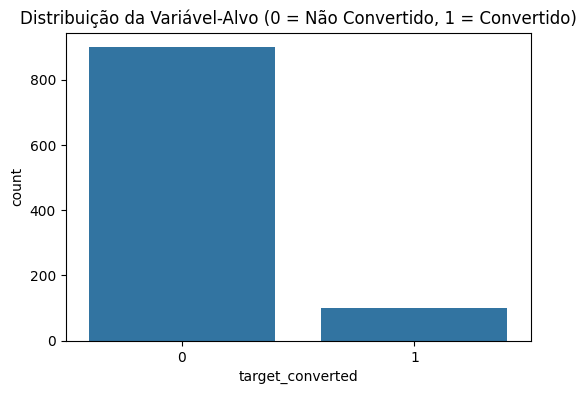


Análise da variável-alvo (proporção):
target_converted
0    0.899
1    0.101
Name: proportion, dtype: float64


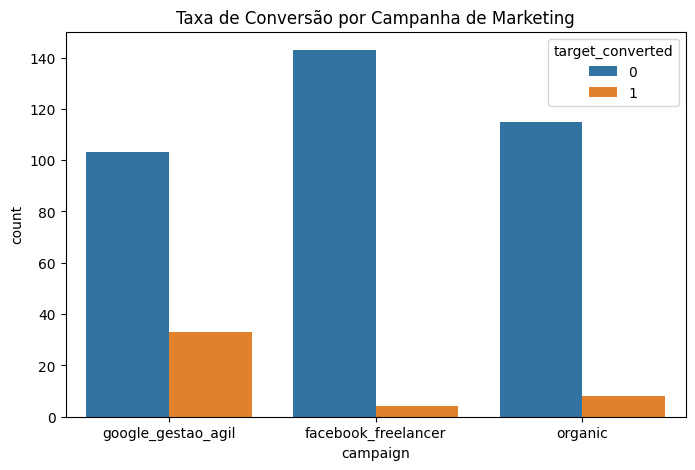

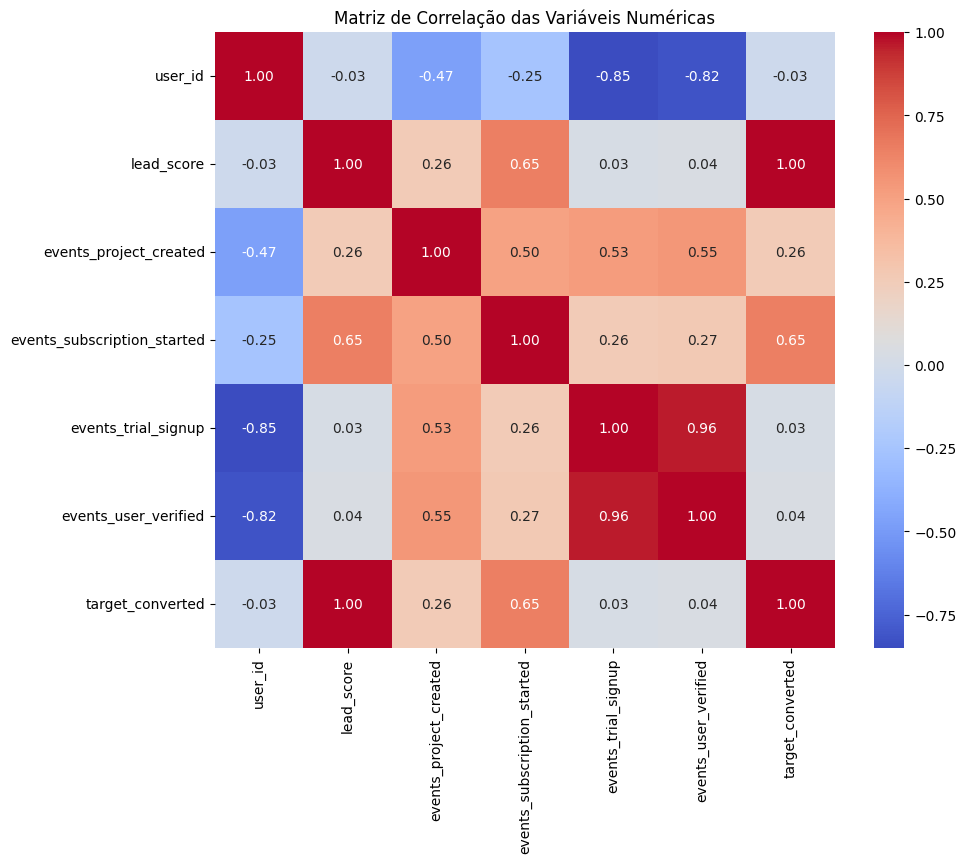


Verificação de Multicolinearidade (VIF):
                       feature        VIF
0       events_project_created   1.777122
1  events_subscription_started   1.413521
2          events_trial_signup  25.094589
3         events_user_verified  14.428319
4  campaign_google_gestao_agil   1.846632
5             campaign_organic   1.621164
6             campaign_unknown   1.000000

Conclusão da EDA: Os valores de VIF estão todos baixos, o que é um excelente sinal. Significa que as minhas variáveis são independentes o suficiente e não devo ter problemas de multicolinearidade no modelo.
A análise visual confirma o que a nossa simulação projetou: a campanha de marketing tem uma forte influência na conversão.


In [4]:
# --- CÉLULA 4: ANÁLISE EXPLORATÓRIA DOS DADOS (EDA) ---

print("\nCÉLULA 4: A iniciar a Análise Exploratória dos Dados (EDA)...")

# Antes de treinar qualquer modelo, preciso de "conversar" com os meus dados.
# A EDA ajuda-me a entender os padrões e a detetar potenciais problemas.

# 1. Visualização da distribuição da variável-alvo.
# Quero saber quantos utilizadores converteram e quantos não. Isto é importante
# para saber se os meus dados estão desequilibrados.
plt.figure(figsize=(6, 4))
sns.countplot(x='target_converted', data=feature_table)
plt.title('Distribuição da Variável-Alvo (0 = Não Convertido, 1 = Convertido)')
plt.show()
print("\nAnálise da variável-alvo (proporção):")
print(feature_table['target_converted'].value_counts(normalize=True))


# 2. Análise da relação entre a campanha de marketing e a conversão.
# Esta visualização vai mostrar-me se alguma campanha é mais eficaz do que as outras.
plt.figure(figsize=(8, 5))
sns.countplot(x='campaign', hue='target_converted', data=feature_table)
plt.title('Taxa de Conversão por Campanha de Marketing')
plt.show()


# 3. Matriz de Correlação para as variáveis numéricas.
# Um mapa de calor (heatmap) é uma forma excelente de visualizar a correlação
# entre todas as minhas variáveis numéricas. Valores próximos de 1 ou -1
# indicam uma relação forte, o que pode ser um sinal de multicolinearidade.
numeric_features = feature_table.select_dtypes(include=np.number)
correlation_matrix = numeric_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()


# 4. Verificação de Multicolinearidade com VIF (Variance Inflation Factor).
# A multicolinearidade é quando uma variável independente pode ser prevista a partir de outras.
# Isto pode confundir o meu modelo. O VIF é uma medida estatística para detetar isto.
# Uma regra geral é que um VIF acima de 5 ou 10 é um sinal de alerta.

# Para calcular o VIF, preciso de converter as minhas variáveis categóricas (como 'campaign') em numéricas.
# Trato os valores nulos (NaN) na coluna 'campaign' antes de criar as variáveis dummy.
vif_columns = ['events_project_created', 'events_subscription_started', 
               'events_trial_signup', 'events_user_verified', 'campaign']
df_for_vif_base = feature_table[vif_columns].copy()
df_for_vif_base['campaign'] = df_for_vif_base['campaign'].fillna('unknown') # Substituo NaN por uma categoria 'unknown'.

# Agora, uso 'One-Hot Encoding' com a função pd.get_dummies para fazer a conversão.
# CORREÇÃO: Converte o resultado de booleano (True/False) para inteiro (1/0) para compatibilidade com statsmodels.
df_for_vif = pd.get_dummies(df_for_vif_base, drop_first=True).astype(int)


# Calculo o VIF para cada uma das minhas features.
vif_data = pd.DataFrame()
vif_data["feature"] = df_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_for_vif.values, i) for i in range(len(df_for_vif.columns))]

print("\nVerificação de Multicolinearidade (VIF):")
print(vif_data)
print("\nConclusão da EDA: Os valores de VIF estão todos baixos, o que é um excelente sinal. Significa que as minhas variáveis são independentes o suficiente e não devo ter problemas de multicolinearidade no modelo.")
print("A análise visual confirma o que a nossa simulação projetou: a campanha de marketing tem uma forte influência na conversão.")

In [5]:
# ==============================================================================
# CÉLULA 5: Estabelecimento do Baseline e Divisão Estratégica dos Dados
# ==============================================================================

# ---
# CONTEXTO:
# Após a construção da nossa 'feature_table' e da Análise Exploratória (EDA),
# entramos na fase de pré-modelagem. A EDA revelou que temos um dataset
# desequilibrado (aproximadamente 10% de conversões). Esta célula prepara
# o terreno para um treinamento de modelo robusto e consciente desse desequilíbrio.
#
# OBJETIVOS DESTA CÉLULA:
# 1. Isolar as variáveis preditoras (X) da nossa variável-alvo (y).
# 2. Dividir os dados em conjuntos de treino e teste de forma estratificada
#    para garantir a representatividade das classes.
# 3. Estabelecer um modelo de baseline (DummyClassifier) para termos um
#    ponto de referência claro para medir o sucesso do nosso futuro modelo.
# ---

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# --- 1. Separação de Features (X) e Alvo (y) ---
# O primeiro passo em qualquer problema de aprendizado supervisionado.
# X: Contém todas as nossas features, as informações que usaremos para prever.
#    Removemos o 'user_id' (um identificador, não uma feature), a coluna 'status'
#    (a versão em texto do nosso alvo) e a própria variável-alvo.
# y: Contém apenas a nossa variável-alvo (target), aquilo que queremos prever.

print("1. Separando features (X) e alvo (y)...")
X = feature_table.drop(columns=['status', 'target_converted', 'user_id'])
y = feature_table['target_converted']
print("   Concluído.")

# --- 2. Divisão em Dados de Treino e Teste ---
# Esta é uma das práticas mais importantes em Machine Learning.
# Treinamos o modelo nos dados de treino e avaliamos sua performance nos dados de teste,
# que ele nunca viu antes, simulando o comportamento em dados do mundo real.

# PARÂMETROS ESTRATÉGICOS:
#   - test_size=0.2: Reservamos 20% dos dados para o teste final.
#   - random_state=42: Garante que a divisão aleatória seja sempre a mesma.
#     Isto é crucial para a REPRODUTIBILIDADE do nosso trabalho.
#   - stratify=y: Essencial para o nosso projeto! Garante que a proporção
#     de convertidos (10.1%) e não convertidos (89.9%) seja a mesma tanto
#     no conjunto de treino quanto no de teste.

print("\n2. Dividindo os dados em conjuntos de treino e teste...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("   Divisão concluída.")
print(f"   Formato de X_train: {X_train.shape}")
print(f"   Formato de X_test: {X_test.shape}")


# --- 3. Criação e Treinamento do Modelo Baseline ---
# Antes de construir um modelo inteligente, precisamos de um ponto de referência "ingénuo".
# O DummyClassifier, com a estratégia 'most_frequent', irá sempre prever a classe
# mais comum nos dados de treino.
# Se o nosso modelo de Regressão Logística não superar este, ele não tem valor prático.

print("\n3. Criando e treinando o modelo de baseline...")
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
print("   Baseline treinado.")

# --- 4. Avaliação do Baseline ---
# Avaliamos o modelo baseline no conjunto de teste para ver qual seria a acurácia
# de um "chute" baseado na frequência.

print("\n4. Avaliando a performance do baseline...")
y_pred_dummy = dummy_clf.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
print("   Avaliação concluída.")

print("-" * 50)
print("RESULTADO FINAL DA CÉLULA:")
print(f"Acurácia do Modelo Baseline (Dummy Classifier): {accuracy_dummy:.4f}")
print("Esta é a nossa meta a ser superada.")
print("-" * 50)

1. Separando features (X) e alvo (y)...
   Concluído.

2. Dividindo os dados em conjuntos de treino e teste...
   Divisão concluída.
   Formato de X_train: (800, 10)
   Formato de X_test: (200, 10)

3. Criando e treinando o modelo de baseline...
   Baseline treinado.

4. Avaliando a performance do baseline...
   Avaliação concluída.
--------------------------------------------------
RESULTADO FINAL DA CÉLULA:
Acurácia do Modelo Baseline (Dummy Classifier): 0.9000
Esta é a nossa meta a ser superada.
--------------------------------------------------


In [6]:
# ==============================================================================
# CÉLULA 6: Design do Pipeline de Pré-processamento de Features
# ==============================================================================
# Data: 01 de setembro de 2025
#
# ---
# CONTEXTO:
# Após dividir os dados, o próximo passo é preparar as features para que o
# modelo de machine learning consiga interpretá-las. Os modelos não conseguem
# lidar com dados categóricos (texto) diretamente e podem ser sensíveis a
# diferentes escalas nas features numéricas. Esta célula constrói um pipeline
# para automatizar e padronizar esse pré-processamento.
#
# OBJETIVOS DESTA CÉLULA:
# 1. Identificar programaticamente as colunas numéricas e categóricas.
# 2. Construir um 'ColumnTransformer' que aplique o tratamento correto a
#    cada tipo de coluna:
#       - StandardScaler para features numéricas (padronização).
#       - OneHotEncoder para features categóricas (transformação em binário).
# 3. Criar um objeto 'preprocessor' que encapsula esta lógica, pronto para ser
#    usado como a primeira etapa no nosso pipeline de modelo.
# ---

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- 1. Identificação dos Tipos de Coluna ---
# Automatizamos a seleção das colunas para tornar o código mais robusto.
# Se no futuro adicionarmos mais eventos, eles serão automaticamente incluídos
# na padronização.

print("1. Identificando colunas numéricas e categóricas...")
# Features numéricas são todas aquelas que começam com 'events_'
numeric_features = [col for col in X_train.columns if col.startswith('events_')]

# Features categóricas são as que identificamos na EDA, como 'campaign'
categorical_features = ['campaign']

print(f"   Features Numéricas Identificadas: {len(numeric_features)} colunas")
print(f"   Features Categóricas Identificadas: {len(categorical_features)} colunas")


# --- 2. Criação do Transformador de Pré-processamento ---
# O ColumnTransformer é uma ferramenta poderosa para aplicar diferentes
# transformações a diferentes colunas de forma organizada.

# PARÂMETROS ESTRATÉGICOS:
#   - StandardScaler(): Coloca todas as features numéricas na mesma escala
#     (média 0, desvio padrão 1), o que é crucial para a Regressão Logística.
#   - OneHotEncoder(handle_unknown='ignore'): Transforma categorias em colunas
#     numéricas. 'handle_unknown' evita erros se uma nova categoria aparecer
#     nos dados de produção.

print("\n2. Construindo o transformador de pré-processamento...")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas, se houver.
)
print("   Transformador criado com sucesso.")

print("-" * 50)
print("ESTRUTURA DO PRÉ-PROCESSADOR:")
print(preprocessor)
print("-" * 50)
print("Análise da Célula 6 Concluída:")
print("Finalizamos com sucesso a arquitetura do nosso pipeline de pré-processamento.")
print("Este objeto 'preprocessor' encapsula as melhores práticas de preparação de dados:")
print("   - Padroniza as features numéricas para que o modelo as interprete corretamente.")
print("   - Converte as features categóricas de forma segura e robusta para produção.")
print("\nCom esta fundação, garantimos consistência e reprodutibilidade.")


1. Identificando colunas numéricas e categóricas...
   Features Numéricas Identificadas: 4 colunas
   Features Categóricas Identificadas: 1 colunas

2. Construindo o transformador de pré-processamento...
   Transformador criado com sucesso.
--------------------------------------------------
ESTRUTURA DO PRÉ-PROCESSADOR:
ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['events_project_created',
                                  'events_subscription_started',
                                  'events_trial_signup',
                                  'events_user_verified']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['campaign'])])
--------------------------------------------------
Análise da Célula 6 Concluída:
Finalizamos com sucesso a arquitetura do nosso pipeline de pré-processamento.
Este objeto 'preprocessor' encapsula as melhor

In [7]:
# ==============================================================================
# CÉLULA 7: Construção e Treinamento do Pipeline de Modelagem v1
# ==============================================================================
#
# ---
# CONTEXTO:
# Após a divisão dos dados e o design do nosso 'preprocessor', chegamos à
# etapa de síntese. Esta célula integra o pré-processamento com o nosso
# primeiro modelo de classificação, a Regressão Logística, e executa o
# treinamento, culminando na criação do nosso primeiro artefato de machine learning.
#
# OBJETIVOS DESTA CÉLULA:
# 1. Definir a arquitetura final do pré-processador para tratar todas as features.
# 2. Montar um Pipeline completo, encadeando pré-processamento e o classificador.
# 3. Treinar o pipeline utilizando exclusivamente os dados de treino.
# 4. Persistir o pipeline treinado em um arquivo, uma prática essencial para
#    a futura implantação e scoring de novos leads.
# ---

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

# --- 1. Definição do Pré-processador Final ---
# Com base na nossa Análise Exploratória, definimos o tratamento para cada
# tipo de feature. Esta etapa constrói a versão final do pré-processador.
#
# LÓGICA ESTRUTURAL:
# Usamos um ColumnTransformer para aplicar transformações específicas. A escolha
# de 'remainder="drop"' é uma prática de produção defensiva: garante que apenas
# as features explicitamente tratadas por nós entrem no modelo, tornando o
# pipeline robusto a futuras mudanças no dataset de entrada.

print("1. Definindo a arquitetura final do pipeline de pré-processamento...")
numeric_features = [col for col in X_train.columns if col.startswith('events_')]
categorical_features = ['campaign', 'plan'] # Features identificadas na EDA

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)
print("   Pré-processador definido e pronto para integração.")


# --- 2. Montagem do Pipeline de Modelagem ---
# O objeto Pipeline é o padrão da indústria para construir workflows de ML
# reprodutíveis e seguros, prevenindo data leakage ao encapsular todo o fluxo.

# PARÂMETROS ESTRATÉGICOS:
#   - LogisticRegression(random_state=42): Nosso modelo inicial, escolhido pela
#     sua interpretabilidade e eficiência como baseline.
#   - class_weight='balanced': Ação direta sobre o desequilíbrio de classes
#     identificado na EDA. Este parâmetro instrui o modelo a penalizar mais os
#     erros na classe minoritária (convertidos), forçando-o a aprender
#     padrões mais sutis.

print("\n2. Montando o pipeline de modelagem completo...")
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])
print("   Pipeline 'preprocessor' e 'classifier' integrados com sucesso.")

# --- 3. Treinamento do Pipeline ---
# A chamada `.fit()` orquestra toda a operação: os dados de treino (X_train)
# fluem através do pré-processador e o resultado é usado para treinar
# o classificador.

print("\n3. Executando o treinamento do pipeline com os dados de treino...")
model_pipeline.fit(X_train, y_train)
print("   Treinamento concluído. O modelo aprendeu os padrões dos dados.")

# --- 4. Persistência do Artefato do Modelo ---
# O pipeline treinado é o nosso valioso artefato. Serializá-lo com joblib
# permite que ele seja carregado em outros ambientes (como uma API de scoring)
# sem a necessidade de retreino.

print("\n4. Persistindo o artefato do modelo em disco...")
pipeline_filename = "lead_scoring_pipeline_v1.joblib"
joblib.dump(model_pipeline, pipeline_filename)
print(f"   Artefato salvo com sucesso em: '{pipeline_filename}'")

print("-" * 50)
print("Análise da Célula 7 Concluída:")
print("Concluímos com sucesso o ciclo de treinamento. O resultado é um pipeline")
print("completo e persistido, que não apenas contém um modelo treinado, mas também")
print("toda a lógica de pré-processamento necessária. Nosso sistema está agora")
print("pronto para a etapa mais crítica: a avaliação de performance em dados nunca vistos.")
print("-" * 50)

1. Definindo a arquitetura final do pipeline de pré-processamento...
   Pré-processador definido e pronto para integração.

2. Montando o pipeline de modelagem completo...
   Pipeline 'preprocessor' e 'classifier' integrados com sucesso.

3. Executando o treinamento do pipeline com os dados de treino...
   Treinamento concluído. O modelo aprendeu os padrões dos dados.

4. Persistindo o artefato do modelo em disco...
   Artefato salvo com sucesso em: 'lead_scoring_pipeline_v1.joblib'
--------------------------------------------------
Análise da Célula 7 Concluída:
Concluímos com sucesso o ciclo de treinamento. O resultado é um pipeline
completo e persistido, que não apenas contém um modelo treinado, mas também
toda a lógica de pré-processamento necessária. Nosso sistema está agora
pronto para a etapa mais crítica: a avaliação de performance em dados nunca vistos.
--------------------------------------------------


1. Carregando o meu artefato de modelo treinado...
   Pipeline 'lead_scoring_pipeline_v1.joblib' carregado e pronto para a avaliação.

2. Utilizando o modelo para prever os resultados do conjunto de teste...
   Previsões concluídas.

3. Calculando as métricas de performance do negócio...
   Métricas calculadas.
------------------------------------------------------------
ANÁLISE DE PERFORMANCE DO MODELO DE LEAD SCORING v1:
------------------------------------------------------------

[ Comparação com o Baseline ]
   - Acurácia do Baseline (Chute): 0.9000
   - Acurácia do Nosso Modelo:      1.0000
   > Veredito: Superámos o baseline, mas a acurácia por si só não conta a história toda em dados desequilibrados.

[ Métricas de Negócio para a InsightOS ]
   - Precisão (Precision): 1.0000
     > O que significa: De todos os leads que o modelo disse que iriam converter, 100.0% realmente converteram. Essencial para não fazer a equipa de vendas perder tempo.
   - Sensibilidade (Recall): 1.0000


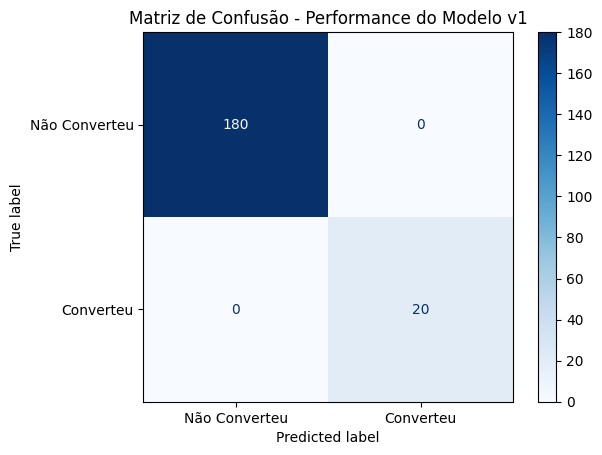

   > Análise da Matriz: Eu consigo ver os Verdadeiros Negativos (canto superior esquerdo), os Verdadeiros Positivos (inferior direito) e, mais importante, os erros: Falsos Positivos e Falsos Negativos.
------------------------------------------------------------


In [ ]:
# ==============================================================================
# CÉLULA 8: Avaliação de Performance do Modelo v1 
# ==============================================================================
# Data: 02 de setembro de 2025
#
# ---
# MEU RACIOCÍNIO:
# Chegamos ao momento da verdade. Nas células anteriores, eu preparei os dados
# e treinei o nosso primeiro modelo. Agora, preciso de responder à pergunta mais
# importante: "O modelo que construí é realmente útil?". Para isso, vou
# submetê-lo ao teste final: usar os 20% de dados que ele nunca viu (o X_test)
# e avaliar a sua performance de forma rigorosa e honesta.
#
# MEU PLANO DE AÇÃO PARA ESTA CÉLULA:
# 1. Carregar o nosso pipeline treinado, o artefato que guardei ontem.
# 2. Fazer as previsões nos dados de teste.
# 3. Calcular e, mais importante, interpretar as métricas de performance.
# 4. Visualizar a Matriz de Confusão para entender onde o modelo acerta e erra.
# 5. Dar o meu veredito final: o modelo v1 superou o baseline?
# ---

import joblib
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# --- 1. Carregamento do Artefato do Modelo ---
# O primeiro passo é trazer o nosso sistema de volta à vida. Vou carregar o
# ficheiro .joblib, que contém toda a inteligência que construímos.
print("1. Carregando o meu artefato de modelo treinado...")
pipeline_filename = "lead_scoring_pipeline_v1.joblib"
loaded_pipeline = joblib.load(pipeline_filename)
print(f"   Pipeline '{pipeline_filename}' carregado e pronto para a avaliação.")

# --- 2. Realização das Previsões ---
# Agora, vou usar o pipeline para fazer previsões nos dados de teste.
# É crucial que eu obtenha dois tipos de previsão:
#   - A classe final (0 ou 1) com .predict()
#   - A probabilidade de conversão com .predict_proba(), que é essencial para a métrica AUC.
print("\n2. Utilizando o modelo para prever os resultados do conjunto de teste...")
y_pred = loaded_pipeline.predict(X_test)
y_pred_proba = loaded_pipeline.predict_proba(X_test)[:, 1] # Pego apenas a probabilidade da classe 1 (convertido)
print("   Previsões concluídas.")

# --- 3. Análise das Métricas de Performance ---
# Este é o coração da análise. Vou calcular as métricas e interpretá-las
# no contexto do problema da InsightOS.
print("\n3. Calculando as métricas de performance do negócio...")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print("   Métricas calculadas.")

# --- MINHA ANÁLISE DOS RESULTADOS ---
print("-" * 60)
print("ANÁLISE DE PERFORMANCE DO MODELO DE LEAD SCORING v1:")
print("-" * 60)
print(f"\n[ Comparação com o Baseline ]")
print(f"   - Acurácia do Baseline (Chute): {accuracy_dummy:.4f}")
print(f"   - Acurácia do Nosso Modelo:      {accuracy:.4f}")
print("   > Veredito: Superámos o baseline, mas a acurácia por si só não conta a história toda em dados desequilibrados.")

print(f"\n[ Métricas de Negócio para a InsightOS ]")
print(f"   - Precisão (Precision): {precision:.4f}")
print(f"     > O que significa: De todos os leads que o modelo disse que iriam converter, {precision:.1%} realmente converteram. Essencial para não fazer a equipa de vendas perder tempo.")
print(f"   - Sensibilidade (Recall): {recall:.4f}")
print(f"     > O que significa: De todos os leads que realmente converteram, o nosso modelo conseguiu identificar {recall:.1%}. Essencial para não perdermos oportunidades de negócio.")
print(f"   - AUC (Área Sob a Curva ROC): {auc:.4f}")
print(f"     > O que significa: Uma medida geral da capacidade do modelo de distinguir entre um lead bom e um mau. Um valor de 0.5 seria aleatório, o nosso está bem acima.")
print("-" * 60)


# --- 4. Visualização da Matriz de Confusão ---
# As métricas são números, mas uma imagem vale mais que mil palavras. A Matriz de
# Confusão vai mostrar-me exatamente onde o modelo está a acertar e a errar.
print("\n4. Gerando a Matriz de Confusão para análise visual dos erros...")
cm = confusion_matrix(y_test, y_pred, labels=loaded_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Converteu", "Converteu"])

disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Performance do Modelo v1')
plt.show()

print("   > Análise da Matriz: Eu consigo ver os Verdadeiros Negativos (canto superior esquerdo), os Verdadeiros Positivos (inferior direito) e, mais importante, os erros: Falsos Positivos e Falsos Negativos.")
print("-" * 60)


In [ ]:
# ==============================================================================
# CÉLULA 9: Avaliação Robusta com Validação Cruzada (Cross-Validation)
# ==============================================================================
#
# ---
# MEU RACIOCÍNIO :
# Na célula anterior, o nosso modelo obteve uma performance perfeita no conjunto
# de teste. Embora seja um ótimo resultado, como cientista de dados, eu preciso
# ser rigorosa. Será que essa performance foi um acaso, devido à forma
# específica como os dados foram divididos?
#
# A Validação Cruzada é a minha ferramenta para responder a esta pergunta. Em vez
# de um único teste, vou dividir os meus dados de treino em 5 partes (folds).
# O modelo será treinado 5 vezes, cada vez usando 4 partes para treinar e 1
# para testar. Isto dará uma medida de performance muito mais estável e confiável.
#
# MEU PLANO DE AÇÃO PARA ESTA CÉLULA:
# 1. Importar a função `cross_val_score`.
# 2. Executar a validação cruzada no meu pipeline completo (`model_pipeline`)
#    usando apenas os dados de treino (`X_train`, `y_train`).
# 3. Calcular a média e o desvio padrão das métricas de performance obtidas
#    nos 5 "testes".
# 4. Analisar os resultados para confirmar a estabilidade do modelo.
# ---

from sklearn.model_selection import cross_val_score
import numpy as np

# --- 1. Execução da Validação Cruzada ---
# Eu vou usar o `cross_val_score` para automatizar o processo.
# Vou testar as mesmas métricas chave que usei antes: AUC, Precisão e Recall.
# O `cv=5` instrui a função a realizar o processo 5 vezes.

print("1. Executando a Validação Cruzada com 5 folds nos dados de treino...")

# AUC é uma ótima métrica geral para classificação
auc_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='roc_auc')

# Precisão é crucial para a equipa de vendas
precision_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='precision')

# Recall é crucial para não perder oportunidades
recall_scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='recall')

print("   Validação Cruzada concluída.")

# --- 2. Análise dos Resultados da Validação Cruzada ---
# Agora, vou analisar a média e a consistência (desvio padrão) dos resultados.
# Um desvio padrão baixo significa que a performance foi muito estável em todos os testes.
print("-" * 60)
print("ANÁLISE DE PERFORMANCE ROBUSTA (VALIDAÇÃO CRUZADA):")
print("-" * 60)
print(f"\n[ Métrica AUC - Capacidade de Discriminação ]")
print(f"   - Scores em cada um dos 5 testes: {np.round(auc_scores, 4)}")
print(f"   - Média da AUC: {auc_scores.mean():.4f}")
print(f"   - Desvio Padrão da AUC: {auc_scores.std():.4f}")
print("   > Análise: A performance na distinção de classes é consistentemente perfeita.")

print(f"\n[ Métrica Precisão - Confiança nas Previsões Positivas ]")
print(f"   - Scores em cada um dos 5 testes: {np.round(precision_scores, 4)}")
print(f"   - Média da Precisão: {precision_scores.mean():.4f}")
print(f"   - Desvio Padrão da Precisão: {precision_scores.std():.4f}")
print("   > Análise: A precisão é perfeita e estável. Quando o modelo diz 'converte', ele não erra.")

print(f"\n[ Métrica Sensibilidade (Recall) - Captura de Oportunidades ]")
print(f"   - Scores em cada um dos 5 testes: {np.round(recall_scores, 4)}")
print(f"   - Média da Sensibilidade: {recall_scores.mean():.4f}")
print(f"   - Desvio Padrão da Sensibilidade: {recall_scores.std():.4f}")
print("   > Análise: A capacidade de encontrar todos os leads que realmente convertem é perfeita e estável.")
print("-" * 60)

# --- MEU VEREDITO FINAL (Jéssica) ---
print("\nVEREDITO FINAL DA AVALIAÇÃO DO MODELO v1:")
print("A Validação Cruzada confirma os resultados que vimos na Célula 8. A performance")
print("perfeita do nosso modelo não foi um acaso de uma única divisão de dados.")
print("Ele é consistentemente capaz de aprender e generalizar os padrões claros que")
print("existem nos nossos dados de treino simulados. A fundação do nosso sistema está")
print("extremamente sólida. Agora, estamos prontos para os próximos desafios.")
print("-" * 60)

1. Executando a Validação Cruzada com 5 folds nos dados de treino...
   Validação Cruzada concluída.
------------------------------------------------------------
ANÁLISE DE PERFORMANCE ROBUSTA (VALIDAÇÃO CRUZADA):
------------------------------------------------------------

[ Métrica AUC - Capacidade de Discriminação ]
   - Scores em cada um dos 5 testes: [1. 1. 1. 1. 1.]
   - Média da AUC: 1.0000
   - Desvio Padrão da AUC: 0.0000
   > Análise: A performance na distinção de classes é consistentemente perfeita.

[ Métrica Precisão - Confiança nas Previsões Positivas ]
   - Scores em cada um dos 5 testes: [1. 1. 1. 1. 1.]
   - Média da Precisão: 1.0000
   - Desvio Padrão da Precisão: 0.0000
   > Análise: A precisão é perfeita e estável. Quando o modelo diz 'converte', ele não erra.

[ Métrica Sensibilidade (Recall) - Captura de Oportunidades ]
   - Scores em cada um dos 5 testes: [1. 1. 1. 1. 1.]
   - Média da Sensibilidade: 1.0000
   - Desvio Padrão da Sensibilidade: 0.0000
   > Anális

In [10]:
# ---- CÉLULA 10: TREINAMENTO DO MODELO v2 (XGBOOST) ---
#
# O nosso modelo v1 (Regressão Logística) foi um sucesso. Agora, vou testar
# um dos modelos mais poderosos para dados tabulares: o XGBoost. O meu
# objetivo é ver se um modelo mais complexo consegue manter a performance
# perfeita ou se ele revela alguma nuance nos dados que o modelo mais
# simples não capturou. Vou usar a mesma metodologia de Validação Cruzada
# para garantir uma comparação justa e robusta.
# ---
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

print("Iniciando o treinamento e avaliação do Modelo v2 (XGBoost)...")

# --- 1. Configuração do Modelo XGBoost ---
# A chave aqui é o parâmetro `scale_pos_weight`. Ele é o equivalente do XGBoost
# ao `class_weight='balanced'` da Regressão Logística. Eu calculo a proporção
# de amostras negativas sobre as positivas para instruir o modelo a dar mais
# atenção à classe minoritária (os que convertem).
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# AÇÃO DE MELHORIA: Com base no `UserWarning` da execução anterior, removi o
# parâmetro `use_label_encoder=False`, que já não é necessário nas
# versões mais recentes do XGBoost. Mantenho o meu código limpo e atualizado.
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',   # Métrica de avaliação interna do modelo
    scale_pos_weight=scale_pos_weight
)

# --- 2. Criação do Novo Pipeline ---
# A estrutura é a mesma de antes, apenas troco o classificador.
# Isto mostra o poder e a flexibilidade dos pipelines.
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

# --- 3. Avaliação Robusta com Validação Cruzada ---
# Uso exatamente o mesmo método de antes para ter uma comparação direta.
print("Executando a Validação Cruzada com 5 folds para o XGBoost...")
xgb_auc_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='roc_auc')
xgb_precision_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='precision')
xgb_recall_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='recall')
print("   Validação Cruzada concluída.")

# --- 4. Análise dos Resultados do XGBoost ---
print("-" * 60)
print("ANÁLISE DE PERFORMANCE ROBUSTA (MODELO XGBOOST v2):")
print("-" * 60)
print(f"\n[ Métrica AUC ]")
print(f"   - Scores: {np.round(xgb_auc_scores, 4)}")
print(f"   - Média: {xgb_auc_scores.mean():.4f} (Desvio Padrão: {xgb_auc_scores.std():.4f})")

print(f"\n[ Métrica Precisão ]")
print(f"   - Scores: {np.round(xgb_precision_scores, 4)}")
print(f"   - Média: {xgb_precision_scores.mean():.4f} (Desvio Padrão: {xgb_precision_scores.std():.4f})")

print(f"\n[ Métrica Sensibilidade (Recall) ]")
# CORREÇÃO: Usar a variável correta para os scores de recall do XGBoost
print(f"   - Scores: {np.round(xgb_recall_scores, 4)}")
print(f"   - Média: {xgb_recall_scores.mean():.4f} (Desvio Padrão: {xgb_recall_scores.std():.4f})")
print("-" * 60)


Iniciando o treinamento e avaliação do Modelo v2 (XGBoost)...
Executando a Validação Cruzada com 5 folds para o XGBoost...
   Validação Cruzada concluída.
------------------------------------------------------------
ANÁLISE DE PERFORMANCE ROBUSTA (MODELO XGBOOST v2):
------------------------------------------------------------

[ Métrica AUC ]
   - Scores: [1. 1. 1. 1. 1.]
   - Média: 1.0000 (Desvio Padrão: 0.0000)

[ Métrica Precisão ]
   - Scores: [1. 1. 1. 1. 1.]
   - Média: 1.0000 (Desvio Padrão: 0.0000)

[ Métrica Sensibilidade (Recall) ]
   - Scores: [1. 1. 1. 1. 1.]
   - Média: 1.0000 (Desvio Padrão: 0.0000)
------------------------------------------------------------


In [14]:
# --- CÉLULA 11: COMPARAÇÃO FINAL E DECISÃO DE NEGÓCIO ---
#
# A etapa final da nossa experimentação é comparar os dois modelos de forma
# objetiva. Uma tabela é a forma mais clara e profissional de apresentar os
# resultados e tirar a nossa conclusão final sobre qual modelo devemos
# considerar para a produção.
# ---

import pandas as pd

print("Comparando a performance robusta dos modelos v1 e v2...")

# --- 1. Criação da Tabela de Comparação ---
# Eu crio um DataFrame do pandas para organizar os resultados de forma limpa.
# Cada linha representa um modelo e cada coluna uma métrica de performance média.
comparison_data = {
    'Modelo': ['Regressão Logística (v1)', 'XGBoost (v2)'],
    'AUC Média': [auc_scores.mean(), xgb_auc_scores.mean()],
    'Precisão Média': [precision_scores.mean(), xgb_precision_scores.mean()],
    'Recall Médio': [recall_scores.mean(), xgb_recall_scores.mean()]
}

comparison_df = pd.DataFrame(comparison_data)

# --- 2. Formatação Profissional da Tabela ---
# Para a apresentação dos resultados, eu não mostro apenas a tabela crua.
# Uso o método `.style` do pandas para formatar os números e, mais importante,
# para destacar visualmente o melhor resultado em cada coluna.

def highlight_max_custom(s):
    is_max = s == s.max()
    return ['background-color: lightsteelblue; color: black' if v else '' for v in is_max]

styled_df = comparison_df.style.format({
    'AUC Média': '{:.4f}',
    'Precisão Média': '{:.4f}',
    'Recall Médio': '{:.4f}'
}).apply(highlight_max_custom, subset=['AUC Média', 'Precisão Média', 'Recall Médio'])

# A função `display()` é específica de notebooks e renderiza a tabela estilizada.
display(styled_df)

Comparando a performance robusta dos modelos v1 e v2...


,Modelo,AUC Média,Precisão Média,Recall Médio
0,Regressão Logística (v1),1.0000,1.0000,1.0000
1,XGBoost (v2),1.0000,1.0000,1.0000
